# Comp255 - Assessment 1 (45431957)

In [35]:
# import packages
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

1) Load Dataset:
2) Visualise Dataset:

'''
At first, we should explore the raw time-series sensor data. We could draw line plot of sensor signals.
In this example code, the wrist sensor accelerometer data dataset_1 sitting activity is visualized.   
'''

In [36]:
# 1) read/load dataset file

df = pd.read_csv('dataset/dataset_1.txt', sep=',', header=None)
print('The dataset contains %d rows.' % len(df)) 
df.head()


The dataset contains 245576 rows.


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.092478,0.14400,-0.009739,231.24,42.410,181.19,-0.13840,-0.85828,0.101680,32.813,...,-6.607700,-15.092,38.214,-0.90671,-0.43698,-0.52616,-91.394,33.158,4.2875,1
1,0.057310,0.16003,-0.009739,238.56,51.564,174.59,-0.15410,-0.86636,0.069517,46.727,...,-5.143100,-18.021,37.482,-0.94272,-0.32132,-0.49881,-82.606,36.087,-1.5711,1
2,0.022143,0.18408,-0.038329,243.69,59.620,166.17,-0.15410,-0.89867,0.053434,57.346,...,-3.678400,-20.584,37.116,-0.92271,-0.21722,-0.46756,-75.283,37.552,-5.9651,1
3,-0.001302,0.20412,-0.030160,246.62,65.112,156.29,-0.16981,-0.90675,0.049414,65.768,...,-0.749080,-23.514,35.285,-0.89070,-0.13626,-0.45193,-69.424,37.552,-8.8945,1
4,-0.032562,0.20813,-0.026076,250.64,70.605,145.30,-0.16981,-0.90675,0.081579,69.063,...,-0.016749,-24.246,33.088,-0.89870,-0.10927,-0.48709,-63.566,39.017,-10.3590,1


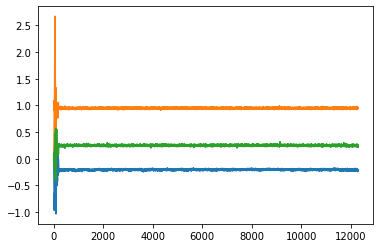

In [37]:
#2) Visualising

df_sitting = df[df[24] == 1].values
# In this example code, only accelerometer 1 data (column 1 to 3) is used
plt.plot(df_sitting[:, 0:3])
plt.show()


3) Remove signal noises

'''
For raw sensor data, it usually contains noise that arises from different sources, such as sensor mis-
calibration, sensor errors, errors in sensor placement, or noisy environments. We could apply filter to remove noise of sensor data
to smooth data. In this example code, Butterworth low-pass filter is applied. 
'''

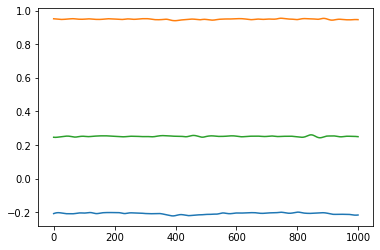

In [46]:
# def noise_removing():
df = pd.read_csv('dataset/dataset_1.txt', sep=',', header=None)
    # Butterworth low-pass filter. You could try different parameters and other filters. 
b, a = signal.butter(4, 0.04, 'lowpass', analog=False)
df_sitting = df[df[24] == 1].values
for i in range(3):
    df_sitting[:,i] = signal.lfilter(b, a, df_sitting[:, i])
plt.plot(df_sitting[500:1500, 0:3])
plt.show()

4) Extract features

'''
To build a human activity recognition system, we need to extract features from raw data and create feature dataset for training machine learning models.
'''

In [47]:
#def feature_engineering_example():
training = np.empty(shape=(0, 10))
testing = np.empty(shape=(0, 10))
# deal with each dataset file
for i in range(19):
    df = pd.read_csv('dataset/dataset_' + str(i + 1) + '.txt', sep=',', header=None)
    print('deal with dataset ' + str(i + 1))
    for c in range(1, 14):
        activity_data = df[df[24] == c].values
        b, a = signal.butter(4, 0.04, 'low', analog=False)
        for j in range(24):
            activity_data[:, j] = signal.lfilter(b, a, activity_data[:, j])
            
        datat_len = len(activity_data)
        training_len = math.floor(datat_len * 0.8)
        training_data = activity_data[:training_len, :]
        testing_data = activity_data[training_len:, :]

        # data segementation: for time series data, we need to segment the whole time series, and then extract features from each period of time
        # to represent the raw data. In this example code, we define each period of time contains 1000 data points. Each period of time contains 
        # different data points. You may consider overlap segmentation, which means consecutive two segmentation share a part of data points, to 
        # get more feature samples.
        training_sample_number = training_len // 1000 + 1
        testing_sample_number = (datat_len - training_len) // 1000 + 1

        for s in range(training_sample_number):
            if s < training_sample_number - 1:
                sample_data = training_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = training_data[1000*s:, :]
            # in this example code, only three accelerometer data in wrist sensor is used to extract three simple features: min, max, and mean value in
            # a period of time. Finally we get 9 features and 1 label to construct feature dataset. You may consider all sensors' data and extract more

            feature_sample = []
            for i in range(3):
                feature_sample.append(np.min(sample_data[:, i]))
                feature_sample.append(np.max(sample_data[:, i]))
                feature_sample.append(np.mean(sample_data[:, i]))
            feature_sample.append(sample_data[0, -1])
            feature_sample = np.array([feature_sample])
            training = np.concatenate((training, feature_sample), axis=0)
            
        for s in range(testing_sample_number):
            if s < training_sample_number - 1:
                sample_data = testing_data[1000*s:1000*(s + 1), :]
            else:
                sample_data = testing_data[1000*s:, :]

            feature_sample = []
            for i in range(3):
                feature_sample.append(np.min(sample_data[:, i]))
                feature_sample.append(np.max(sample_data[:, i]))
                feature_sample.append(np.mean(sample_data[:, i]))
            feature_sample.append(sample_data[0, -1])
            feature_sample = np.array([feature_sample])
            testing = np.concatenate((testing, feature_sample), axis=0)

df_training = pd.DataFrame(training)
df_testing = pd.DataFrame(testing)
df_training.to_csv('training_data.csv', index=None, header=None)
df_testing.to_csv('testing_data.csv', index=None, header=None)

deal with dataset 1
deal with dataset 2
deal with dataset 3
deal with dataset 4
deal with dataset 5
deal with dataset 6
deal with dataset 7
deal with dataset 8
deal with dataset 9
deal with dataset 10
deal with dataset 11
deal with dataset 12
deal with dataset 13
deal with dataset 14
deal with dataset 15
deal with dataset 16
deal with dataset 17
deal with dataset 18
deal with dataset 19


The dataset contains 245576 rows.


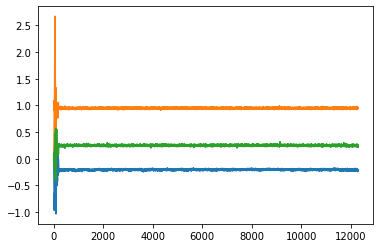